# Example: Pseudo-contact shift

In [109]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

## Build the spin-system

In [110]:
ex=RS.ExpSys(v0H=850,Nucs=['13C','e-'],T_K=298)
Aiso=5000
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=Aiso,Ayy=Aiso,Azz=Aiso)
print(f'We expect a pseudo-contact shift of {Aiso*ex.Peq[1]/2} Hz')

We expect a pseudo-contact shift of -112.55288149360537 Hz


## Define the Liouvillian, add relaxation, acquire the propagator

Note that by default, we do not cause the system to relax to thermal equilibrium, but rather to 0. However, for the Pseudocontact shift, we only obtain the effect if the electronic states have thermal polarization, so we need to enforce relaxation to thermal equilibrium (Peq=True).

In [111]:
L=RS.Liouvillian(ex)     #Liouville object
L.add_relax(Type='T1',i=1,T1=1e-6,Peq=True)  #Add T1 relaxation (1 ns). 
L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
dt=1/1000/2 #Short enough time step for 2000 Hz spectral width
U=L.U(t0=0,tf=dt)

## Prepare the System

In [112]:
rho=RS.Rho(rho0='13Cx',detect='13Cp',L=L)

rho.clear()
seq=RS.Sequence(L)
seq.add_channel('13C',t=[0,2.5e-6],v1=[100000,0],phase=[np.pi/2,0])
Upi2=seq.U(tf=2.5e-6)
#Upi2*rho


## Acquire

<AxesSubplot:xlabel='$\\nu$ / kHz', ylabel='I / a.u.'>

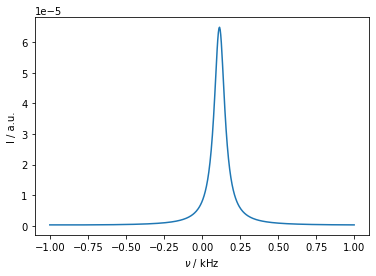

In [113]:
rho.DetProp(U,n=512)
rho.plot(FT=True,imag=False,apodize=True)